   # Extending Single Domain Approach: the effect of interactions

## Here it will be implemented 'my approach' to include interactions in the in the free energy density within the Stoner-Wohlfarth framework. It will be addressed magnetic interactions, such as dipole-dipole, exchange and dzyaloshinskii-moriya to calculate magnetization curves. Basically, for a given particle 'j' of the array in the step 'k' of the hysteresis procedure, the magnetization value ( described by $(\theta_j,\phi_j)$) of its neighbors will be approximated by its value in the step 'k-1'th (previous computation of the magnetic moments orientation). In this way, starting from technical saturation at high fields, the magnetization angles of the whole array can be calculated through common energy minimization procedures. The approach succeeds when the field-step is small enough to assure convergence of the calculations.

In [1]:
# the necessary import statements!

# to paralelize and accelerate the calculations
import numba
from numba import jit
from numba import njit


import joblib
from joblib import Parallel, delayed
import multiprocessing


# numpy for fast calculations using arrays
import numpy as np

# scipy for minimization
import scipy
from scipy import optimize
from scipy.optimize import minimize as spmin
from scipy.optimize import Bounds

# some trigonometric functions
from math import pi, sin, cos, sqrt
import math

# to plot graphics
import matplotlib.pyplot as plt
%matplotlib inline

# the time of some calculations
import timeit

import dlib

import random


In [5635]:
# parameters of the simulation

Msat=float(1000)
Ms=float(1/1000)

K1=float(((1*1.0)*10**3))
K2=float((-0*1.0*10**4))
Kuni=float((-1*1.0*10**3))
Kuni2=float((0*0.2*10**2))
K1mel=float((1*2.0*10**3))
Neff=float(1*1.000)
#field-dependent anisotropy
Kfd=float(-0*0.30*10**0)
#Krot=float((1*2.50*10**4))
Krot=float((-1*2.50*10**3))
Krot2=float((-0*1.80*10**3))
htheta=float(+1*pi/2.)
hphi=float(3*pi/4+5*pi/180.)

# Nanoparticle arrangement order
#1-> square
np_order = 1


NN=1**3
NN2=1**2

# interaction strengths!

beta = 0.1



In [5636]:
# applied field parameters

hini=200.*1
hfinal=-200.*1
step=1500
stepmag=0.15/step
stepmag=0.50/step
hpasso=(hfinal-hini)/step
print(K1,K2,Krot,Msat)

1000.0 0.0 -2500.0 1000.0


In [5637]:
# the function that defines the common magnetic anisotropy terms
#@jit(nopython=True,parallel=True)
def anisotropy(phi,theta,K1,K2,h,htheta,hphi,Msat):

# first-order cubic magnetocrystalline anisotropy
    anis=K1/(Msat**2)*(np.sin(phi)**2*np.cos(phi)**2*np.sin(theta)**4+np.sin(phi)**2*np.sin(theta)**2*np.cos(theta)**2+np.cos(phi)**2*np.sin(theta)**2*np.cos(theta)**2)

# second-order cubic magnetocrystalline anisotropy    
    anis+=K2/(Msat**2)*np.sin(phi)**2*np.sin(theta)**2*np.cos(phi)**2*np.sin(theta)**2*np.cos(theta)**2

# demagnetizing energy
    anis+=2*3.1415*Neff*np.cos(theta)**2

# magelas anisotropy 
    
    anis+=K1mel/(Msat**2)*np.cos(phi)**2*np.sin(theta)**2
    
    
# uniaxial anisotropy 
    
    anis+=Kuni/(Msat**2)*np.sin(phi-3.1415/4.)**2*np.sin(theta-3.1415/4.)**2
    
# uniaxial anisotropy 
    
    anis+=Kuni2/(Msat**2)*np.sin(phi-3.1415/4.)**4*np.sin(theta-3.1415/4.)**4

# field dependent anis!

#    anis+=Kfd/(Msat**2)*h*Msat*(np.sin(htheta)*np.sin(theta)*np.cos(phi-hphi)+np.cos(htheta)*np.cos(theta))
    anis+=Kfd/(Msat**2)*h*Msat**2*(np.sin(theta)*np.cos(phi-3.1415/4.))**2
    
# rotatable anis!

#    anis+=Krot/(Msat**2)*(h*Msat)**1*(np.sin(htheta)*np.sin(theta)*np.cos(phi-hphi)+np.cos(htheta)*np.cos(theta))**2
    anis+=Krot/(Msat**2)*(np.sin(htheta)*np.sin(theta)*np.cos(phi-hphi)+np.cos(htheta)*np.cos(theta))**1

    anis+=Krot2/(Msat**2)*(np.sin(htheta)*np.sin(theta)*np.cos(phi-hphi)+np.cos(htheta)*np.cos(theta))**4
    
    
    return anis
    

In [5638]:
# Zeeman Energy

#@jit(nopython=True,parallel=True)
def zeeman_energy(phi,theta,K1,K2,h,htheta,hphi,Msat):
    
    zeeman=-h*(np.sin(htheta)*np.sin(theta)*np.cos(phi-hphi)+np.cos(htheta)*np.cos(theta))


    return zeeman


In [5639]:
# creating positions!
# this is for creating positions!

#@jit(nopython=True,parallel=True)
def create_pos(np_order,NN2):
    
    if(np_order==1):
        
        nnx=int(sqrt(NN2))
        nny=int(sqrt(NN2))
        
        coord_pos = []
        
        for i in range(nnx):

            for j in range(nnx):
                
                coord_pos.append([i,j,0])
    
    return np.array(coord_pos,dtype=np.float64)


In [5640]:
# this is to create the angles, which are used in the computation of the interactions!

#@jit(nopython=True,parallel=True)
def angles_vecs(NN2):

    ar_pos=create_pos(np_order,NN2)
    
    x_coord = [ar_pos[i][0] for i in range(NN2)]
    y_coord = [ar_pos[i][1] for i in range(NN2)]
    z_coord = [ar_pos[i][2] for i in range(NN2)]

    x_ang = []
    y_ang = []
    
    for i in range(NN2):
        x_ang_menor=[]
        y_ang_menor=[]
        
        for j in range(NN2):
            
            if(i!=j):
                innerproduct = x_coord[i]*x_coord[j]+y_coord[i]*y_coord[j]

                dist1 = sqrt(x_coord[i]**2+y_coord[i]**2+z_coord[i]**2)
                dist2 = sqrt(x_coord[j]**2+y_coord[j]**2+z_coord[j]**2)
                
                distnewvec = sqrt((x_coord[j]-x_coord[i])**2+(y_coord[j]-y_coord[i])**2+(z_coord[j]-z_coord[i])**2)
                distnewvecplane = sqrt((x_coord[j]-x_coord[i])**2+(y_coord[j]-y_coord[i])**2)
                
                if(distnewvecplane!=0.0):
                    angphi = math.acos((x_coord[j]-x_coord[i])/distnewvecplane)
                    angtheta = math.acos((z_coord[j]-z_coord[i])/distnewvec)
                elif(distnewvecplane == 0.0):
                    angphi = 0.0
                    angtheta = 3.1415/2.
                x_ang_menor.append(angphi)
                y_ang_menor.append(angtheta)
                
            elif(i==j):
                
                x_ang_menor.append(0.0)
                y_ang_menor.append(0.0)
                
        x_ang.append(x_ang_menor)
        y_ang.append(y_ang_menor)
        x_ang_menor=[]
        y_ang_menor=[]
                
              
                
    return x_ang,y_ang

In [5641]:
# the interactions

#@jit(nopython=True,parallel=True)
def energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j):

    #obtaining the angles to calculate the interactions!
    
    x_ang,y_ang = angles_vecs(NN2)
    
    phiant = phiantarray[j]
    thetaant = thetaantarray[j]
# dipolar energy

#    create_pos(np_order,NN2)
    inter_dipolar=-3*beta*(np.sin(theta)*sin(y_ang[i][j])*cos(phi-x_ang[i][j])+cos(theta)*cos(y_ang[i][j]))*(sin(thetaant)*sin(y_ang[i][j])*cos(phiant-x_ang[i][j])+cos(thetaant)*cos(y_ang[i][j]));
    inter_dipolar+=beta*(sin(theta)*sin(thetaant)*cos(phi-phiant)+cos(theta)*cos(thetaant))

    return inter_dipolar
    
# exchange energy

# moriya energy



In [5642]:
# energy array

#@jit(nopython=True,parallel=True)
def energy_array_inter(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j):

    listaNN1=[0. for x in range(int(sqrt(NN2))-2)]
    
    for x in range(0,int(sqrt(NN2))-2):
        listaNN1[x] = int(sqrt(NN2))-x-2
                                
    listaNN2=[0. for x in range(int(sqrt(NN2))-2)]
    
    for x in range(0,int(sqrt(NN2))-2):
        listaNN2[x] = int(sqrt(NN2))*(x+2)-1
                                
    listaNN3=[0. for x in range(int(sqrt(NN2))-2)]
    
    for x in range(0,int(sqrt(NN2))-2):
        listaNN3[x] = NN2-x-2
    
    listaNN4=[0. for x in range(int(sqrt(NN2))-2)]
    
    for x in range(0,int(sqrt(NN2))-2):
        listaNN4[x] = int(sqrt(NN2))*(x+1)


                                
    for x in range(NN2):
                                
        for y in range(int(sqrt(NN2))-2):
                                
            if(listaNN1[y]==x):
                                
                foi=-1
                                
            elif(listaNN2[y]==x):
                                
                foi=-2
                                
            elif(listaNN3[y]==x):
                                
                foi=-3
                                
            elif(listaNN4[y]==x):
                                
                foi=-4
                                
            else:
                                
                foi=-5
                                
                                
                                
    print(i,j)
    
    # defining the energy array!
    energy_vec=[0 for x in range(NN2)]
    
    
    if(np_order==1):
        
        if(i==0):
        
            dip_b=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,0,1)
            dip_b+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,0,int(sqrt(NN2)))
            dip_b+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,0,int(sqrt(NN2))-1)
            dip_b+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,0,NN2-int(sqrt(NN2)))
            
            
            energy_vec[i]=dip_b

    
        elif(foi==-1):
            
            dip_f=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-1)
            dip_f+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i+1)
            dip_f+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i+int(sqrt(NN2)))
            dip_f+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,NN2-int(sqrt(NN2))+i)
                                
    
            energy_vec[i]=dip_f

        elif(i==int(sqrt(NN2)-1)):
                                
            dip_c=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,int(sqrt(NN2))-1,int(sqrt(NN2))-2)
            dip_c+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,int(sqrt(NN2))-1,2*int(sqrt(NN2))-1)
            dip_c+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,int(sqrt(NN2))-1,0)
            dip_c+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,int(sqrt(NN2))-1,NN2-1)

            energy_vec[i]=dip_c

        elif(foi==-2):
                                
            dip_q=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-1)
            dip_q+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i+int(sqrt(NN2)))
            dip_q+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-int(sqrt(NN2)))
            dip_q+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-int(sqrt(NN2))+1)
            
            energy_vec[i]=dip_q

        elif(i==NN2-1):
                                
            dip_e=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,NN2-1,NN2-1-int(sqrt(NN2))-2)
            dip_e+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,NN2-1,NN2-1-1)
            dip_e+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,NN2-1,NN2-1-int(sqrt(NN2))+1)
            dip_e+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,NN2-1,int(sqrt(NN2))-1)
                                
            energy_vec[i]=dip_e

        elif(i==NN2-int(sqrt(NN2))):
                                
            dip_d=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,NN2-int(sqrt(NN2)),NN2-int(sqrt(NN2))+1)
            dip_d+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,NN2-int(sqrt(NN2)),NN2-2*int(sqrt(NN2)))
            dip_d+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,NN2-int(sqrt(NN2)),NN2-1)
            dip_d+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,NN2-int(sqrt(NN2)),0)
                                
            energy_vec[i]=dip_d
                                
        elif(foi==-3):
                                
            dip_g=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-1)
            dip_g+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i+1)
            dip_g+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-int(sqrt(NN2)))
            dip_g+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-i%(int(sqrt(NN2))))
            
            energy_vec[i]=dip_g
                                
        elif(foi==-4):
                                
            dip_p=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i+1)
            dip_p+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i+int(sqrt(NN2)))
            dip_p+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-int(sqrt(NN2)))
            dip_p=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i+int(sqrt(NN2))-1)
                                
            energy_vec[i]=dip_p
                                
        else:
                                
            dip_a=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i+1)
            dip_a+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-1)
            dip_a+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-int(sqrt(NN2)))
            dip_a+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i+int(sqrt(NN2)))
                                
            energy_vec[i]=dip_a
                                
    
                                
                                
                                
                                
                                
    return energy_vec
                                
                                
                                
                                
                                
                                
                                
                                

In [5643]:

ar_pos=create_pos(np_order,NN2)

ar_pos[8][0]

x_coord = [ar_pos[i][0] for i in range(NN2)]
y_coord = [ar_pos[i][1] for i in range(NN2)]
z_coord = [ar_pos[i][2] for i in range(NN2)]

print(x_coord)
print(y_coord)
print(z_coord)


IndexError: index 8 is out of bounds for axis 0 with size 1

In [5644]:
a,b=angles_vecs(NN2)
int(sqrt(NN2))

1

In [5645]:
energy_vec=[0 for x in range(NN2)]

energy_vec[1]=2

energy_vec

IndexError: list assignment index out of range

In [5646]:
phiantarray=[0.0*x for x in range(NN2)]
thetaantarray=[0.5 for x in range(NN2)]
h=0.1

energy_array_inter(0.8,0.2,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,3,1)




3 1


UnboundLocalError: local variable 'foi' referenced before assignment

In [5647]:
#@jit(nopython=True,parallel=True)
def free_energy(xx,K1,K2,h,htheta,hphi,Msat):

    anis = anisotropy(xx[0],xx[1],K1,K2,h,htheta,hphi,Msat)
    
    zeeman = zeeman_energy(xx[0],xx[1],K1,K2,h,htheta,hphi,Msat)

    expr_calc = anis + zeeman
    
#    return np.array(expr_calc,dtype=np.float64)
    return expr_calc
    
    

In [5648]:
#testing!
h=-5.01
x0=np.array([0,1.57],dtype=np.float64)
a=free_energy(np.array([0,1.57],dtype=np.float64),K1,K2,h,htheta,hphi,Msat)
minxy=spmin(free_energy,x0,args=(K1,K2,h,htheta,hphi,Msat),bounds=[[-100*3.1415,100*3.1415],[-100*3.1415,100*3.1415]],tol=1e-100,options={'ftol': 1e-30})
print(minxy)

      fun: -5.00658049626058
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([8.8817842e-08, 0.0000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 27
      nit: 6
   status: 0
  success: True
        x: array([-0.69850835,  1.5708528 ])


In [5649]:
# the main program, where minimization of overall energy is performed!



def hysteresis_inter(NN2,Msat):
    
    
    hnow=hini/Msat
    maglist=[]
    maglistend=[]
    Msat0=Msat
    
    for particle in range(NN2):
        
        Msat=Msat0
        maglistend0=[]
        hnow=hini/Msat
        htest=[]
        hlist=[]
        for i in range(1,int(step+1)):
            
            if(hnow>=0):
                coefmag=(1+(step/2-i)*stepmag)
            else:
                coefmag=(1+(i-step/2)*stepmag)
            if(i==1):
                    
                angx=hphi#+np.pi
                angy=htheta#+np.pi
                
                h=hnow
                    
                Msat=Msat0*coefmag
                
                
                x0=np.array([angx,angy],dtype=np.float64)
                
                
                minxy=spmin(free_energy,[x0],args=(K1,K2,h,htheta,hphi,Msat),bounds=[[-100*3.1415,100*3.1415],[-100*3.1415,100*3.1415]],tol=1e-100,options={'ftol': 1e-30})

            
                angx=minxy.x[0]
                angy=minxy.x[1]
#                dfsol=minxy.x[2]
                
#                hlist.append(hnow*Msat)
                maglist.append(coefmag*((np.sin(htheta)*np.sin(angy)*np.cos(angx-hphi)+np.cos(htheta)*np.cos(angy))))
        
                hnow=hnow+hpasso/Msat
 
                
            if(i!=1):

                Msat=Msat0*coefmag
                #            x0=np.array([angx,angy,dfsol],dtype="float")
                x0=np.array([angx,angy],dtype=np.float64)
                h=hnow
                
                minxy=spmin(free_energy,x0,args=(K1,K2,h,htheta,hphi,Msat),bounds=[[-10000*3.1415,10000*3.1415],[-10000*3.1415,10000*3.1415]],tol=1e-100,options={'ftol': 1e-30})
                
                angx=minxy.x[0]
                angy=minxy.x[1]
                
                maglist.append(coefmag*((np.sin(htheta)*np.sin(angy)*np.cos(angx-hphi)+np.cos(htheta)*np.cos(angy))))
#                hlist.append(hnow*Msat)

                
                hnow=hnow+hpasso/Msat
                htest.append(minxy)
                
        maglistend0.append(np.array(maglist)) 
        maglist=[]        
    maglistend2=[]
    for i in range(len(maglistend0[0])):
        soma=0
        for j in range(len(maglistend0)):
            soma+=maglistend0[j][i]

        maglistend2.append(soma)
            
    maglistend.append(np.array(maglistend2)) 
    
    hlist=[((hini+hpasso*x)) for x in range(step)]
    
    return maglistend0,hlist,htest




In [5650]:
m_inter,h_inter,h_test = hysteresis_inter(NN2,Msat)

In [5651]:
Msat

1000.0

In [5652]:
h_inter[1]

199.73333333333332

In [5653]:
m_inter[0]

array([ 1.24964403,  1.24931063,  1.24897723, ..., -1.24929508,
       -1.24962854, -1.24996201])

In [5654]:
h_test[5]


      fun: -0.19973755859845613
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([5.55111512e-09, 2.77555756e-09])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 33
      nit: 6
   status: 0
  success: True
        x: array([2.43738402, 1.57084631])

In [5655]:
Msat

1000.0

In [5656]:
h

-5.01

(-200, 200)

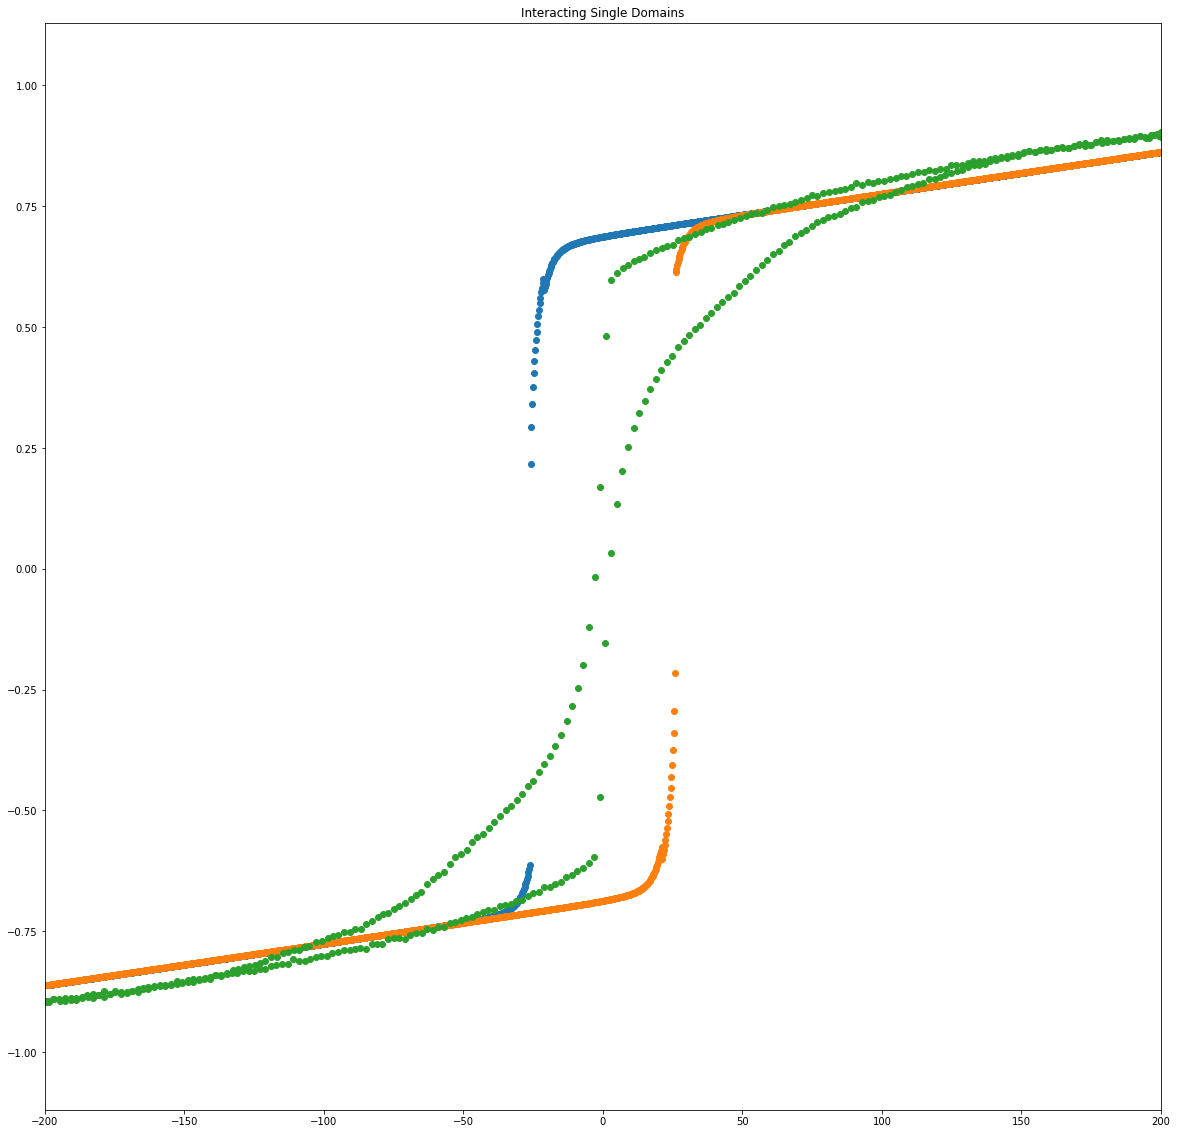

In [5657]:
import matplotlib.pyplot as plt

norm=1.45

plt.figure(figsize=(20,20))

plt.title("Interacting Single Domains")

plt.scatter(h_inter,np.array(m_inter)/norm)
plt.scatter(-np.array(h_inter),-np.array(m_inter)/norm)

plt.scatter(hexp_on,mexp_on)

plt.xlim(-200,200)


In [5187]:
# experimental data
path='/home/vagner/Desktop/galfenol/gal90deg.txt'
#path='/home/vagner/Desktop/galfenol/gal50deg.txt'
#path = '/home/vagner/Desktop/galfenol/gal0deg.txt'

hexp10ktube = open(path,'r')
hexp=hexp10ktube.readlines()

print(hexp[0])
#print(a1[0][1])

hexp_on=[]
mexp_on=[]
hexp10ktube.close()
for i in range(len(hexp)):
    listexp=hexp[i].split('\t')
    hexp_on.append(float(listexp[0]))
    mexp_on.append(float(listexp[1].split('\n')[0]))

9999.71436	1



In [653]:
mexp_on

[1.0,
 1.00695,
 1.00004,
 1.0004,
 1.00389,
 1.00086,
 0.99877,
 0.99804,
 1.00266,
 1.00052,
 1.00239,
 0.99823,
 0.99803,
 0.99877,
 1.00102,
 0.99751,
 1.00358,
 1.00254,
 0.99539,
 1.00127,
 0.99812,
 1.00226,
 0.999,
 0.99776,
 1.00261,
 0.99949,
 0.99963,
 0.99747,
 1.0004,
 1.00075,
 0.99874,
 1.00296,
 1.00025,
 0.99917,
 1.00391,
 1.00512,
 1.00211,
 1.00047,
 1.00242,
 0.99889,
 0.99728,
 1.00001,
 1.00088,
 1.00627,
 1.00083,
 1.00361,
 1.00425,
 1.00492,
 1.00284,
 1.00541,
 1.00075,
 1.00382,
 1.002,
 1.00219,
 1.00378,
 1.00405,
 1.00036,
 1.00268,
 1.00364,
 1.00117,
 1.00434,
 1.00277,
 1.00227,
 1.0005,
 1.00384,
 1.00039,
 1.00131,
 1.00532,
 1.0037,
 1.00128,
 1.00236,
 1.00221,
 1.00159,
 1.00121,
 1.00586,
 1.00302,
 1.00317,
 1.0054,
 1.0024,
 1.006,
 1.00332,
 1.00454,
 1.0075,
 1.00274,
 1.00307,
 1.00181,
 1.006,
 1.0009,
 1.00283,
 1.00024,
 1.00014,
 1.00183,
 1.00384,
 1.00358,
 1.00512,
 1.00044,
 1.00279,
 1.0015,
 1.00171,
 1.0071,
 1.00538,
 1.00221,
 1